## Outcome prediction after Chikungunya hospitalization

#### MC853 - Unicamp

- Leandro Henrique Silva Resende – 213437 

- Pietro Grazzioli Golfeto – 223694 

- Yvens Ian Prado Porto – 184031 

In [1]:
# Required Libraries
# We used Python 3.10.12
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import (StratifiedKFold)
from sklearn.metrics import precision_score
import time
from sklearn.metrics import (roc_auc_score,           # For evaluating model performance
                             recall_score)   
from sklearn.svm import SVC                           # For Support Vector Classifier
from sklearn.linear_model import LogisticRegression   # For Logistic Regression Classifier
from sklearn.ensemble import (RandomForestClassifier, # For ensemble classifiers
                              GradientBoostingClassifier,
                              BaggingClassifier)
from sklearn.neural_network import MLPClassifier      # For Multi-layer Perceptron Classifier
from sklearn.neighbors import KNeighborsClassifier  # For K-Nearest Neighbors Classifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
# Paths to the data (change according to your system)
leandro_path = {
    'X_train_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/X_train.csv',
    'y_train_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/y_train.csv',
    'X_test_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/X_test.csv',
    'y_test_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/y_test.csv',
}

pietro_path = {
    'X_train_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_train.csv',
    'y_train_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_train.csv',
    'X_test_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_test.csv',
    'y_test_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_test.csv',
}

In [3]:
# Set the path based on the user
if os.path.isfile(leandro_path['X_train_path']):
    path = leandro_path
elif os.path.isfile(pietro_path['X_train_path']):
    path = pietro_path
else:
    raise Exception('Path not found. Please check the paths in the script.')

# Get CSV files path (modify to match your file path)
X_train_path = os.path.expanduser(path['X_train_path'])
y_train_path = os.path.expanduser(path['y_train_path'])
X_test_path = os.path.expanduser(path['X_test_path'])
y_test_path = os.path.expanduser(path['y_test_path'])

In [4]:
X_train = pd.read_csv(X_train_path, low_memory=False)
y_train = pd.read_csv(y_train_path, low_memory=False)
X_test = pd.read_csv(X_test_path, low_memory=False)
y_test = pd.read_csv(y_test_path, low_memory=False)

In [5]:
X_train.head()

,AGE,GENDER,PREGNANT,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,...,REGION_MIDWEST,REGION_SOUTHEAST,REGION_SOUTH,TIME_DIFF_DAYS,TIME,WHITE,BLACK,YELLOW,BROWN,INDIGENOUS
0,10.0,0,0.0,1,1,1,1,0,1,1,...,0,0,0,1,26,0,0,0,1,0
1,29.0,1,0.0,1,1,1,1,0,1,1,...,0,0,0,5,25,0,0,0,1,0
2,11.0,1,0.0,1,1,1,0,0,0,0,...,0,0,0,2,37,0,0,0,1,0
3,5.0,1,0.0,1,0,1,0,0,1,0,...,0,0,0,31,38,0,0,0,1,0
4,11.0,1,0.0,1,1,1,0,0,0,0,...,0,0,0,3,32,0,0,0,1,0


In [6]:
X_train.columns

Index(['AGE', 'GENDER', 'PREGNANT', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA',
       'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA',
       'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES',
       'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT',
       'AUTO_IMUNE', 'CONFIRMED_CASE', 'CRITERIO', 'REGION_NORTH',
       'REGION_NORTHEAST', 'REGION_MIDWEST', 'REGION_SOUTHEAST',
       'REGION_SOUTH', 'TIME_DIFF_DAYS', 'TIME', 'WHITE', 'BLACK', 'YELLOW',
       'BROWN', 'INDIGENOUS'],
      dtype='object')

In [7]:
X_train[['AGE', 'TIME_DIFF_DAYS', 'TIME']].head()

,AGE,TIME_DIFF_DAYS,TIME
0,10.0,1,26
1,29.0,5,25
2,11.0,2,37
3,5.0,31,38
4,11.0,3,32


In [8]:
# # Drop CRITERIO column (not relevant with CONFIRMED_CASE)
X_train['CRITERIO'].value_counts()
X_train = X_train.drop(columns=['CRITERIO'])
X_test = X_test.drop(columns=['CRITERIO'])

In [9]:
def impute_missing(data_train, data_test, n_neighbors=3):
    """
    Impute missing values using the K-nearest neighbors algorithm.

    Parameters:
        data (pd.DataFrame): Input DataFrame with missing values.
        n_neighbors (int, optional): Number of neighbors to use for imputation. Defaults to 3.

    Returns:
        pd.DataFrame: DataFrame with missing values imputed using KNN.
    """
    # Initialize KNNImputer with the specified number of neighbors
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Perform imputation
    imputed_data_train = imputer.fit_transform(data_train)
    imputed_data_test = imputer.transform(data_test)

    # Convert the imputed array back to a DataFrame
    imputed_df_train = pd.DataFrame(imputed_data_train, columns=data_train.columns, index=data_train.index)
    imputed_df_test = pd.DataFrame(imputed_data_test, columns=data_test.columns, index=data_test.index)

    return imputed_df_train, imputed_df_test


In [10]:
X_train, X_test = impute_missing(X_train, X_test, n_neighbors=3)

In [11]:
# Remove rows where TIME_DIFF_DAYS > 60 -> consider as outlier, before normalization
scaler = RobustScaler()
X_train[['AGE', 'TIME_DIFF_DAYS', 'TIME']] = scaler.fit_transform(X_train[['AGE', 'TIME_DIFF_DAYS', 'TIME']])

In [12]:
X_train[['AGE', 'TIME_DIFF_DAYS', 'TIME']].describe()

,AGE,TIME_DIFF_DAYS,TIME
count,21726.000000,21726.000000,21726.000000
mean,0.052730,0.572770,0.053436
std,0.612048,2.019177,0.522004
min,-0.794872,-0.750000,-0.756345
25%,-0.487179,-0.375000,-0.426396
50%,0.000000,0.000000,0.000000
75%,0.512821,0.625000,0.573604
max,2.256410,21.750000,0.832487


In [13]:
pipeline = Pipeline(steps=[
    ('o', SMOTE(sampling_strategy=0.4, random_state=42)),  # Increase minority to 40% of majority
    ('u', RandomUnderSampler(sampling_strategy=1.0, random_state=42))  # Then balance both classes equally
])

X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

In [14]:
print(y_train.sum())
print(y_train_balanced.sum())
print(y_train_balanced.value_counts())

EVOLUCAO    1586
dtype: int64
EVOLUCAO    8056
dtype: int64
EVOLUCAO
0           8056
1           8056
Name: count, dtype: int64


In [15]:
# Set the number of folds for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grids
param_grids = {
    'knn': {
         'n_neighbors': [1, 3, 5, 10],
         'p': [1, 2],
         'weights': ['uniform', 'distance']
    },
    'logistic_regression': {
         # Use 'balanced' or a dict assigning more weight to class 0 (assuming class 1 weight stays 1)
         'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
    },
    'random_forest': {
         'n_estimators': [10, 100, 200],
         'max_depth': [10, 50],
         'min_samples_split': [2, 10, 30],
         'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]     
    }
}

In [16]:
from sklearn.metrics import make_scorer, fbeta_score, recall_score, precision_score

sc_f2          = make_scorer(fbeta_score, beta=2, pos_label=1)   # ← new main scorer
sc_recall_0    = make_scorer(recall_score,    pos_label=0)
sc_precision_0 = make_scorer(precision_score, pos_label=0)
sc_precision_1 = make_scorer(precision_score, pos_label=1)
sc_recall_1    = make_scorer(recall_score,    pos_label=1)

In [ ]:
# Define the base estimators
base_estimators = {
    'random_forest': RandomForestClassifier(random_state=0, n_jobs=-1),
    'logistic_regression': LogisticRegression(random_state=0, n_jobs=-1),
    'knn': KNeighborsClassifier(n_jobs=-1)
}

algorithms = {}
for alg in base_estimators:
    algorithms[alg] = GridSearchCV(
        estimator  = base_estimators[alg],
        param_grid = param_grids[alg],
        cv         = kf,
        n_jobs     = -1,
        scoring    = {'recall_1'    : sc_recall_1},
        refit      = 'recall_1'
    )


# # Create the algorithms dictionary with GridSearchCV wrappers
# algorithms = {}
# for alg in base_estimators:
#     algorithms[alg] = GridSearchCV(
#         estimator=base_estimators[alg],
#         param_grid=param_grids[alg],
#         cv=5,           # Internal cross-validation for grid search
#         n_jobs=-1       # Use all available cores for parallelization
#     )

In [18]:
# # Define a dictionary containing various classification algorithms

# algorithms = {    
#     'random_forest': RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=2, random_state=0, n_jobs=-1),
#     # Random Forest Classifier
    
#     'logistic_regression': LogisticRegression(class_weight='balanced', random_state=0, n_jobs=-1),
#     # Logistic Regression Classifier

#     'knn': KNeighborsClassifier(n_neighbors=5, p=2, weights='uniform', n_jobs=-1),
#     # K-Nearest Neighbors Classifier    
# }

In [19]:
def evaluate_cv(X_train, y_train):
    '''
    Receives data to be evaluated and returns the average performance inside cross-validation, using 3 metrics.
    Applies over-under sampling to get balanced datasets and standardizes features.
    
    Parameters:
    data : DataFrame
        The dataset containing features and the target variable.
    
    Returns:
    df : DataFrame
        A DataFrame containing the mean and standard deviation of each algorithm's performance across 5-fold cross-validation.
        The performance metrics include AUC (mean and standard deviation), sensitivity (mean and standard deviation),
        specificity (mean and standard deviation), prec_n (mean and standard deviation), and prec_p (mean and standard deviation).
    '''
 # Record the start time
    start_time = time.time()
    
    # Initialize dictionaries for performance metrics
    sen = {}
    spe = {}
    auc = {}
    prec_n = {}  # Negative precision
    prec_p = {}  # Positive precision
    
    # Initialize dictionaries to store best hyperparameters and best grid-search scores for each fold
    best_params_all = {algorithm: [] for algorithm in algorithms.keys()}
    best_scores_all = {algorithm: [] for algorithm in algorithms.keys()}
    
    for algorithm in algorithms.keys():
        sen[algorithm] = []
        spe[algorithm] = []
        auc[algorithm] = []
        prec_n[algorithm] = []
        prec_p[algorithm] = []

    # Iterate through each round of the cross-validation
    for train_idx, val_idx in kf.split(X_train, y_train):
        # Allocate train and validation data
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Iterate through each algorithm (each wrapped with GridSearchCV)
        for algorithm, clf in algorithms.items():
            clf.fit(X_train_fold, y_train_fold)
            
            # Save best hyperparameters and the best score from grid-search for this fold
            best_params_all[algorithm].append(clf.best_params_)
            best_scores_all[algorithm].append(clf.best_score_)
            
            # Make predictions for the validation data (using the best estimator found)
            y_pred = clf.predict(X_val_fold)

            # Calculate sensitivity and specificity 
            recallscore = recall_score(y_val_fold, y_pred, labels=[0, 1], average=None)
            sen[algorithm].append(recallscore[1])
            spe[algorithm].append(recallscore[0])

            # Calculate precision for each class
            prec_score = precision_score(y_val_fold, y_pred, labels=[0, 1], average=None)
            prec_n[algorithm].append(prec_score[0])
            prec_p[algorithm].append(prec_score[1])

            # Calculate the area under the ROC curve
            aucscore = roc_auc_score(y_val_fold, clf.predict_proba(X_val_fold)[:, 1])     
            auc[algorithm].append(aucscore)

    # Create a DataFrame with the mean and standard deviation of each algorithm's performance across CV folds
    df = pd.DataFrame(columns=list(algorithms.keys()))

    df.loc['auc (mean)']  = [np.mean(auc['random_forest']), np.mean(auc['logistic_regression']), np.mean(auc['knn'])]
    df.loc['auc (stdev)'] = [np.std(auc['random_forest']),  np.std(auc['logistic_regression']),  np.std(auc['knn'])]

    df.loc['rcl_1 (mean)']  = [np.mean(sen['random_forest']), np.mean(sen['logistic_regression']), np.mean(sen['knn'])]
    df.loc['rcl_1 (stdev)'] = [np.std(sen['random_forest']),  np.std(sen['logistic_regression']), np.std(sen['knn'])]

    df.loc['rcl_0 (mean)']  = [np.mean(spe['random_forest']), np.mean(spe['logistic_regression']), np.mean(spe['knn'])]
    df.loc['rcl_0 (stdev)'] = [np.std(spe['random_forest']),  np.std(spe['logistic_regression']), np.std(spe['knn'])]

    df.loc['prc_1 (mean)']  = [np.mean(prec_p['random_forest']), np.mean(prec_p['logistic_regression']), np.mean(prec_p['knn'])]
    df.loc['prc_1 (stdev)'] = [np.std(prec_p['random_forest']),  np.std(prec_p['logistic_regression']), np.std(prec_p['knn'])]

    df.loc['prc_0 (mean)']  = [np.mean(prec_n['random_forest']), np.mean(prec_n['logistic_regression']), np.mean(prec_n['knn'])]
    df.loc['prc_0 (stdev)'] = [np.std(prec_n['random_forest']),  np.std(prec_n['logistic_regression']), np.std(prec_n['knn'])]

    # Print out the best hyperparameters and grid search scores for each algorithm
    print("\nBest hyperparameters (per fold) and corresponding internal grid-search scores:")
    for alg in algorithms.keys():
        print(f"\nModel: {alg}")
        print("Best parameters for each fold:")
        for i, (params, score) in enumerate(zip(best_params_all[alg], best_scores_all[alg])):
            print(f"  Fold {i+1}: {params} | GridSearchCV best score: {score:.4f}")

    # Record the end time and print total time taken
    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTotal time taken to run cross-validation: {total_time:.2f} seconds")
    
    # Display and return the performance metrics DataFrame
    # display(df)
    return df

In [20]:
evaluate_cv(X_train_balanced, y_train_balanced)

/home/pietro/Desktop/DataSUS-Chikungunya-ML/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/pietro/Desktop/DataSUS-Chikungunya-ML/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/pietro/Desktop/DataSUS-Chikungunya-ML/.venv/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/pietro/Desktop/DataSUS-Chikungunya-ML/.venv/lib/python3.10/site-packages/sklearn/b


Best hyperparameters (per fold) and corresponding internal grid-search scores:

Model: random_forest
Best parameters for each fold:
  Fold 1: {'class_weight': {0: 1, 1: 3}, 'max_depth': 50, 'min_samples_split': 30, 'n_estimators': 200} | GridSearchCV best score: 0.9001
  Fold 2: {'class_weight': {0: 1, 1: 3}, 'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 100} | GridSearchCV best score: 0.9011
  Fold 3: {'class_weight': {0: 1, 1: 3}, 'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 100} | GridSearchCV best score: 0.9019
  Fold 4: {'class_weight': {0: 1, 1: 3}, 'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 200} | GridSearchCV best score: 0.9006
  Fold 5: {'class_weight': {0: 1, 1: 3}, 'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 200} | GridSearchCV best score: 0.8993

Model: logistic_regression
Best parameters for each fold:
  Fold 1: {'class_weight': {0: 1, 1: 3}} | GridSearchCV best score: 0.8406
  Fold 2: {'class_weight': {0: 1, 1: 3}} | 

,random_forest,logistic_regression,knn
auc (mean),0.956715,0.767395,0.914225
auc (stdev),0.005394,0.005940,0.003725
rcl_1 (mean),0.918570,0.944638,0.980512
rcl_1 (stdev),0.012620,0.004955,0.002308
rcl_0 (mean),0.835538,0.308840,0.847938
rcl_0 (stdev),0.047696,0.008577,0.005753
prc_1 (mean),0.849969,0.577488,0.865755
prc_1 (stdev),0.033406,0.004126,0.004553
prc_0 (mean),0.911715,0.847891,0.977528
prc_0 (stdev),0.008855,0.014460,0.002711


random forest: pode ter overfitting, usou o máximo de parâmetros possível

regressão logística: classes quase balanceadas: pesos iguais ficou melhor

KNN usou numero de vizinhos = 1 e distância de manhattan como melhor modelo da busca em grade
justificativa: maldição da dimensionalidade (30 e poucas dimensões, pontos ficam muito distantes)

comentar tradeoff entre precison e recall (exemplo random_forest e knn invertem)

In [21]:
for name, gs in algorithms.items():
    print(name, gs.best_params_)

random_forest {'class_weight': {0: 1, 1: 3}, 'max_depth': 50, 'min_samples_split': 10, 'n_estimators': 200}
logistic_regression {'class_weight': {0: 1, 1: 3}}
knn {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


In [22]:
algorithms['random_forest'].best_estimator_

RandomForestClassifier(class_weight={0: 1, 1: 3}, max_depth=50,
                       min_samples_split=10, n_estimators=200, n_jobs=-1,
                       random_state=0)

In [27]:
def test_model(algorithms, X_test, y_test):
    """
    Evaluate every best_estimator_ stored inside an algorithms dict on test data.

    Parameters
    ----------
    algorithms : dict[str, GridSearchCV]
        Keys are model names, values are *fitted* GridSearchCV objects.
    X_test : array-like or pd.DataFrame
    y_test : array-like or pd.Series

    Returns
    -------
    pd.DataFrame
        Metrics for each model (rows: metrics, cols: model names).
    """
    auc, sen, spe, prec_p, prec_n = {}, {}, {}, {}, {}

    for name, gs in algorithms.items():
        model = gs.best_estimator_

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # AUC
        auc[name] = roc_auc_score(y_test, y_prob)

        # recall for each class → sensitivity (positive) & specificity (negative)
        recall = recall_score(y_test, y_pred, labels=[0, 1], average=None)
        spe[name] = recall[0]   # class 0
        sen[name] = recall[1]   # class 1

        # precision for each class
        prec  = precision_score(y_test, y_pred, labels=[0, 1], average=None)
        prec_n[name] = prec[0]
        prec_p[name] = prec[1]

    # build a tidy table
    df = pd.DataFrame({
        "auc"   : auc,
        "rec_1" : sen,      # sensitivity / recall of class 1
        "rec_0" : spe,      # specificity / recall of class 0
        "prc_1" : prec_p,   # precision of class 1
        "prc_0" : prec_n    # precision of class 0
    }).T          # transpose: metrics as rows

    return df

In [28]:
results_test = test_model(algorithms, X_test, y_test)
print(results_test)

       random_forest  logistic_regression       knn
auc         0.635085             0.681027  0.551670
rec_1       0.307500             0.596250  0.467500
rec_0       0.846879             0.691977  0.635840
prc_1       0.144028             0.139555  0.097118
prc_0       0.935880             0.953391  0.934431


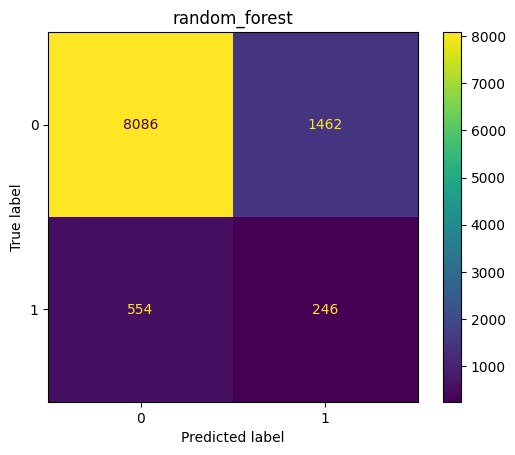

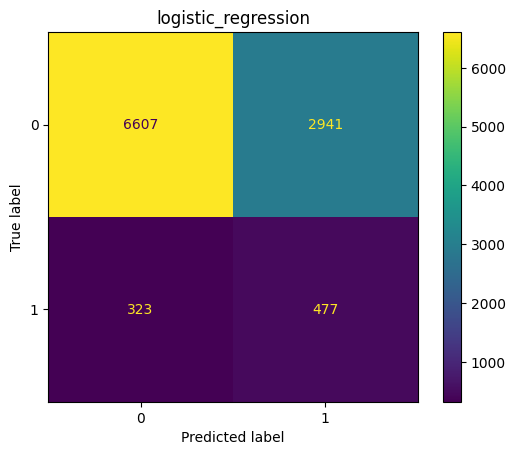

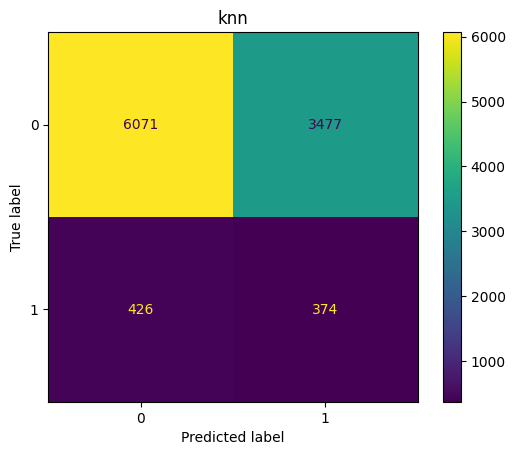

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, gs in algorithms.items():
    y_pred = gs.best_estimator_.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0,1])
    plt.title(name)
    plt.show()

In [26]:
y_test.value_counts(normalize=True)

EVOLUCAO
0           0.92269
1           0.07731
Name: proportion, dtype: float64

<!-- augmentação ferrou a classe 1
proporção real é 7.7%, mas colocamos 40% no treino
modelo aprendeu que proporção é quase meio a meio
tá tendo 5-9 falsos positivos para cada positivo real -->